# **Deep Learning Project**

## **Phase 2**



*   Sobhan Asasi    
(400206392)
*   Mohammad Hajipour   
(401301843)
*   Amin Robatian   
(400301075)




# Requirements

In [1]:
# !pip install pycm
# !pip install torchtext
# !pip install transformers

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

from transformers import BertTokenizer
from transformers import BertModel

import pickle
import os

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import ast

import itertools
import re
import os
import contextlib
from typing import Any, Callable, Dict, IO, Iterable, Iterator, List, Optional, Tuple, TypeVar
import requests
from torch.utils.model_zoo import tqdm
import zipfile

import glob

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

import warnings
warnings.filterwarnings('ignore')

import scipy
from collections import Counter
from tqdm import tqdm
import re 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from pycm import *

Using cuda device


In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Download Dataset Functions

In [4]:
def create_dataset_directory(root, dataset_name):
        
        filename_dict = {'train':'train.zip',
                         'dev':'dev.zip',
                         'test':'test.zip',
                         'MSCTD_data_train':'MSCTD_data_train.zip',
                         'MSCTD_data_dev':'MSCTD_data_dev.zip',
                         'MSCTD_data_test':'MSCTD_data_test.zip'}
        
        id_dict = {'train':'156yOz7M1sAfz4RK6OEQoPsaaPOMhrsT6',
                   'dev':'1URhTfBeUQiAmzb_2gxtn4MCXUxFywGnR',
                   'test':'1MbzM9Twe5KCWAKwZYvZO_OK-v8qRVSPF',
                   'MSCTD_data_train':'1AEwXhfMApCWzGyGr6KRzPtx7hBy3jZXt',
                   'MSCTD_data_dev': '1h3YnPZlIdSqPsggoms1zK2ZF5enSBcDH',
                   'MSCTD_data_test':'1pYWqfTd9rZuQuKgL0wv34Ybz5OINI6SV'}
        
        isExist = os.path.exists(os.path.join(root, dataset_name))
        
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(os.path.join(root, dataset_name))
            print("The " +dataset_name+ " directory is created!")
            print('Downloading ...')
            download_file_from_google_drive(id_dict['MSCTD_data_'+dataset_name],
                                            os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]))
            download_file_from_google_drive(id_dict[dataset_name],
                                os.path.join(root, dataset_name, filename_dict[dataset_name]))
            
            _extract_zip(os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]),os.path.join(root, dataset_name))
            _extract_zip(os.path.join(root, dataset_name, filename_dict[dataset_name]),os.path.join(root, dataset_name))
            
        if(dataset_name=='train'):
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0]+'_ende')]
        else:
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0])]
        
        return list_path_out


def download_file_from_google_drive(file_id: str, fpath: str):
    """Download a Google Drive file from  and place it in root.
    Args:
        file_id (str): id of file to be downloaded
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the id of the file.
    """

    url = "https://drive.google.com/uc"
    params = dict(id=file_id, export="download")
    with requests.Session() as session:
        response = session.get(url, params=params, stream=True)

        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                token = value
                break
        else:
            api_response, content = _extract_gdrive_api_response(response)
            token = "t" if api_response == "Virus scan warning" else None

        if token is not None:
            response = session.get(url, params=dict(params, confirm=token), stream=True)
            api_response, content = _extract_gdrive_api_response(response)

        if api_response == "Quota exceeded":
            raise RuntimeError(
                f"The daily quota of the file {fpath} is exceeded and it "
                f"can't be downloaded. This is a limitation of Google Drive "
                f"and can only be overcome by trying again later."
            )

        _save_response_content(content, fpath)

    # In case we deal with an unhandled GDrive API response, the file should be smaller than 10kB and contain only text
    if os.stat(fpath).st_size < 10 * 1024:
        with contextlib.suppress(UnicodeDecodeError), open(fpath) as fh:
            text = fh.read()
            # Regular expression to detect HTML. Copied from https://stackoverflow.com/a/70585604
            if re.search(r"</?\s*[a-z-][^>]*\s*>|(&(?:[\w\d]+|#\d+|#x[a-f\d]+);)", text):
                warnings.warn(
                    f"We detected some HTML elements in the downloaded file. "
                    f"This most likely means that the download triggered an unhandled API response by GDrive. "
                    f"Please report this to torchvision at https://github.com/pytorch/vision/issues including "
                    f"the response:\n\n{text}"
                )

def _extract_gdrive_api_response(response, chunk_size: int = 32 * 1024) -> Tuple[bytes, Iterator[bytes]]:
    content = response.iter_content(chunk_size)
    first_chunk = None
    # filter out keep-alive new chunks
    while not first_chunk:
        first_chunk = next(content)
    content = itertools.chain([first_chunk], content)

    try:
        match = re.search("<title>Google Drive - (?P<api_response>.+?)</title>", first_chunk.decode())
        api_response = match["api_response"] if match is not None else None
    except UnicodeDecodeError:
        api_response = None
    return api_response, content


def _save_response_content(
    content: Iterator[bytes],
    destination: str,
    length: Optional[int] = None,
) -> None:
    with open(destination, "wb") as fh, tqdm(total=length) as pbar:
        for chunk in content:
            # filter out keep-alive new chunks
            if not chunk:
                continue

            fh.write(chunk)
            pbar.update(len(chunk))


def _extract_zip(from_path: str, to_path: str) -> None:
    with zipfile.ZipFile(
        from_path, "r", compression=zipfile.ZIP_STORED
    ) as zip:
        zip.extractall(to_path)


In [5]:
def files_to_dataframe(text_add, sentiment_add, index_add):
    """
    This function convert all necessary .txt files to a single dataframe

    Args :
    text_add : .txt of chats.
    sentiment_add : .txt of emotions for each line.
    index_add : .txt of related images for each line.

    Output -> pd.dataframe

    """
    df_text = pd.read_csv(text_add, delimiter = "\r\t", header=None, engine='python')
    df_text.columns = ['text']

    df_sentiment = pd.read_csv(sentiment_add, delimiter = "\t", header=None)
    df_sentiment.columns = ['label']

    df_index = pd.read_csv(index_add, delimiter = "\t", header=None)
    df_index.columns = ['indexes']
        
    lst = [df_text, df_sentiment, df_index]  # List of your dataframes
    df_result = pd.concat(lst, axis =1)

    return df_result

---
# Part (1) - TF-IDF (Term Frequency-Inverse Document Frequency) 


tf-idf provides a weight of how relavent a perticular word is to the document or text context

https://en.wikipedia.org/wiki/Tf-idf

In [6]:
# Use TfidfVectorizer to transform input texts into tfidf encoded float point matrix
vectorizer = TfidfVectorizer(stop_words="english")

### Create Dataset Class

In [7]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', text_transform=None, random_state=42, clean_pattern=None):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.text_transform = text_transform
        self.clean_pattern = clean_pattern

        
        # clean our texts
        if self.clean_pattern is not None:
            for i in range(len(self.dataframe)):
                text =  re.sub(self.clean_pattern, " ", self.dataframe.text[i])
                text = text.lower().strip()
                self.dataframe.text[i] = text
        else:
            for i in range(len(self.dataframe)):
                text =  self.dataframe.text[i]
                text = text.lower().strip()
                self.dataframe.text[i] = text
                    
                    
        
        if dataset_name == 'train':
            # Learn vocabulary from training texts and vectorize training texts.
            self.vectorized_text = vectorizer.fit_transform(self.dataframe.text)
        else:
            # Vectorize test/dev texts.
            self.vectorized_text = vectorizer.transform(self.dataframe.text)
            
        # Convert tfidf sparse matrix into pytorch float type tensor in order to feed into pytorch neural network
        self.vectorized_text = torch.tensor(scipy.sparse.csr_matrix.todense(self.vectorized_text)).float()
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        
        return self.vectorized_text[idx], label

In [8]:
train_dataset =  MSCTDDataset(root = './data1', dataset_name = 'train', clean_pattern="[^a-zA-Z0-9]")
test_dataset =  MSCTDDataset(root = './data1', dataset_name = 'test', clean_pattern="[^a-zA-Z0-9]")
dev_dataset =  MSCTDDataset(root = './data1', dataset_name = 'dev', clean_pattern="[^a-zA-Z0-9]")

In [9]:
print(f'Number of all sentences in train dataset is: {len(train_dataset):,}')
print(f'Number of all sentences in test dataset is: {len(test_dataset):,}')
print(f'Number of all sentences in development dataset is: {len(dev_dataset):,}')

Number of all sentences in train dataset is: 20,240
Number of all sentences in test dataset is: 5,067
Number of all sentences in development dataset is: 5,063


In [10]:
sample_train = train_dataset[0]
#print(sample_train)
print(f'Sample Vectorized Sentence: {sample_train[0]}')
print(f'Sample Vectorized Sentence Shape: {sample_train[0].shape}')
print(f'Sample Label: {sample_train[1]}')

Sample Vectorized Sentence: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Sample Vectorized Sentence Shape: torch.Size([9277])
Sample Label: 0


### Dataloader

In [11]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Neural Network

In [12]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dev_dataset[0][0].shape[0], 3)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, 3)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.fc1(x.to(torch.float))
        x = self.softmax(x)
        
        return x

In [13]:
model_MLP_tf_idf = MLP().to(device)

In [14]:
pytorch_total_params = sum(p.numel() for p in model_MLP_tf_idf.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 28,029


### Training Loop

In [15]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs, criterion, optimizer):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_input = train_input.to(device)
                train_label = train_label.to(device)

                output = model(train_input)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    
                    val_input = val_input.to(device)
                    val_label = val_label.to(device)

                    output = model(val_input)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {(100 * total_acc_train / len(train_dataset)): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {(100 * total_acc_val / len(dev_dataset)): .2f}%')

In [16]:
EPOCHS = 10
LR = 2e-3
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_MLP_tf_idf.parameters(), lr=LR)

train(model_MLP_tf_idf, train_loader, dev_loader, LR, EPOCHS, criterion, optimizer)

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 53.85it/s]


Epochs: 1 | Train Loss:  0.002                 | Train Accuracy:  40.01%                 | Val Loss:  0.002                 | Val Accuracy:  37.80%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 141.19it/s]


Epochs: 2 | Train Loss:  0.002                 | Train Accuracy:  43.14%                 | Val Loss:  0.002                 | Val Accuracy:  39.74%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 143.26it/s]


Epochs: 3 | Train Loss:  0.002                 | Train Accuracy:  46.00%                 | Val Loss:  0.002                 | Val Accuracy:  41.26%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 143.67it/s]


Epochs: 4 | Train Loss:  0.002                 | Train Accuracy:  51.52%                 | Val Loss:  0.002                 | Val Accuracy:  43.16%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 136.71it/s]


Epochs: 5 | Train Loss:  0.002                 | Train Accuracy:  54.54%                 | Val Loss:  0.002                 | Val Accuracy:  44.20%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 143.71it/s]


Epochs: 6 | Train Loss:  0.002                 | Train Accuracy:  58.11%                 | Val Loss:  0.002                 | Val Accuracy:  45.09%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 140.01it/s]


Epochs: 7 | Train Loss:  0.002                 | Train Accuracy:  59.79%                 | Val Loss:  0.002                 | Val Accuracy:  45.45%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 145.99it/s]


Epochs: 8 | Train Loss:  0.002                 | Train Accuracy:  61.02%                 | Val Loss:  0.002                 | Val Accuracy:  46.28%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 145.65it/s]


Epochs: 9 | Train Loss:  0.002                 | Train Accuracy:  62.56%                 | Val Loss:  0.002                 | Val Accuracy:  46.89%


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 142.86it/s]


Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  63.40%                 | Val Loss:  0.002                 | Val Accuracy:  47.15%


### Evaluate Model on Test Data

In [17]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for test_input, test_label in test_dataloader:

            test_input = test_input.to(device)
            test_label = test_label.to(device)

            output = model(test_input)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            test_label = test_label.data.cpu().numpy()
            y_true.extend(test_label) # Save Truth
            
    return y_true, y_pred

In [18]:
model_MLP_tf_idf.eval()
y_true, y_pred = evaluate(model_MLP_tf_idf, test_loader)

### Results

Accuracy: 49.16%

F1 score: 44.16%

Confusion Matrix:


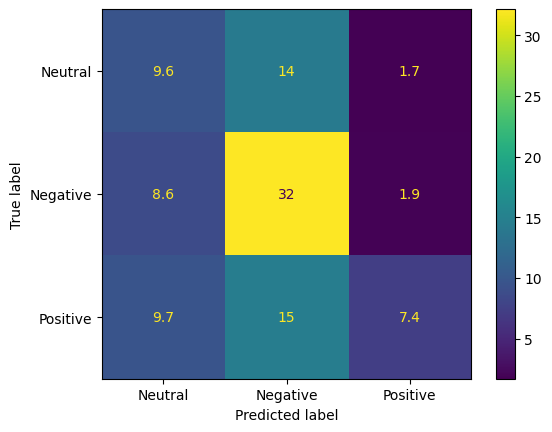

In [19]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

---
# Part (2) - SVD

### Create Embedding With SVM Parameter

In [20]:
def create_svm_dataset(dataframe, dict_data):
    
    total_name = []
    total_weight = []
    
    for i in tqdm(range(len(dataframe))):

        wrd_list = clean_doc(dataframe.text[i], "[^a-zA-Z]")

        list_arr = []
        list_name = []
        for j in range(len(wrd_list)):
            try:
                list_arr.append(dict_data[wrd_list[j]])
                list_name.append(wrd_list[j])
            except:
                continue

        if(len(list_name)==0):
            continue

        total_name.extend(list_name)

        data_x = np.zeros((len(list_name), len(dataframe)))
        label_x = np.ones((len(list_name), 1))

        for k in range(len(list_arr)):
            data_x[k,:] = list_arr[k]

        for s in range(len(list_name)):

            data_y = np.zeros((len(list_name), len(dataframe)))
            label_y = np.zeros((len(list_name), 1))
            s = 0 
            while(1):
                dict_sample = random.sample(dict_data.items(), 1)
                if dict_sample[0][0] in list_name:
                    continue
                else:
                    data_y[s,:] = dict_sample[0][1]
                    s += 1
                    if(s == len(list_name)):
                        break

            #Create a svm Classifier
            clf = svm.SVC(kernel='linear') # Linear Kernel

            #Train the model using the training sets
            clf.fit(np.concatenate((data_y, data_x), axis=0), np.concatenate((label_y, label_x), axis=0))
            s = clf.get_params(deep=True)
            total_weight.extend(clf.coef_)
                                
    return total_name, total_weight  
                                
def clean_doc(txt, clean_pattern):
    txt =  re.sub(clean_pattern, " ", txt)
    txt = txt.lower().strip()
    out = []
    for i in txt.split(' '):
        if(i != '' and len(i)>1):
            out.append(i)
    return out

def Average(lst):
    return sum(lst) / len(lst)

def create_weight_dict(dict_data, word_dct, weight_dct):           
    weight = {}
    for i in dict_data.keys():
        list_value = []
        for j in range(len(word_dct)):
            if(i==word_dct[j]):
                list_value.append(weight_dct[j])
        weight[i] = Average(list_value)
                                
    return weight


def svm_embedding():
                                
    txt_train = './data1/train/MSCTD_data_train/english_train.txt'
    sentiment_train = './data1/train/MSCTD_data_train/sentiment_train.txt'
    img_train = './data1/train/MSCTD_data_train/image_index_train.txt'
    dataframe = files_to_dataframe(txt_train, sentiment_train, img_train)

    clean_pattern = "[^a-zA-Z]" 

    if clean_pattern is not None:
        for i in range(len(dataframe)):
            text =  re.sub(clean_pattern, " ", dataframe.text[i])
            text = text.lower().strip()
            dataframe.text[i] = text
    else:
        for i in range(len(dataframe)):
            text =  dataframe.text[i]
            text = text.lower().strip()
            dataframe.text[i] = text

    vectorizer = TfidfVectorizer(stop_words="english")
    vectorized_text = vectorizer.fit_transform(dataframe.text)
    vectorized_text = np.array(scipy.sparse.csr_matrix.todense(vectorized_text))
    feature = vectorizer.get_feature_names_out()
    
    dict_data = {}
    for i in range(vectorized_text.shape[1]):
        dict_data[feature[i]] = vectorized_text[:, i]
                                
    word_dct, weight_dct  = create_svm_dataset(dataframe, dict_data)
    svm_param = create_weight_dict(dict_data, word_dct, weight_dct)
                                
    return dict_data, svm_param 

def svm_tokenizer(dict_data, text):
    wrd_list = clean_doc(text, "[^a-zA-Z]")
    list_name = []
    for j in range(len(wrd_list)):
        try:
            dict_data[wrd_list[j]]
            list_name.append(wrd_list[j])
        except:
            continue
    return list_name  

### Loading SVM Embedding Model

In [21]:
tfidf_param, svm_param = svm_embedding()

100%|█████████████████████████████████████| 20240/20240 [06:59<00:00, 48.30it/s]


### Create Dataset Class

In [22]:
embed_len = 20240
max_words = 5

class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', text_transform=None, random_state=42, clean_pattern=None):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.text_transform = text_transform
        self.clean_pattern = clean_pattern

        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        indexes = self.dataframe.loc[idx, 'indexes']
        tokenized_text = svm_tokenizer(tfidf_param, text)
        
        x_tensor = torch.zeros(max_words, embed_len)
#         print(len(tokenized_text))
        for i in range(min(len(tokenized_text), max_words)):
            x_tensor[i] = torch.tensor(svm_param[tokenized_text[i]])
            
        x_tensor = torch.reshape(x_tensor, (-1,))
    
        return x_tensor, label

In [23]:
train_dataset =  MSCTDDataset(root = './data1', dataset_name = 'train', clean_pattern="[^a-zA-Z]")
test_dataset =  MSCTDDataset(root = './data1', dataset_name = 'test', clean_pattern="[^a-zA-Z]")
dev_dataset =  MSCTDDataset(root = './data1', dataset_name = 'dev', clean_pattern="[^a-zA-Z]")

### Dataloader

In [24]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Neural Network

In [25]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(max_words*embed_len, 3)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, 3)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.fc1(x.to(torch.float))
        x = self.softmax(x)
        
        return x

In [26]:
model_MLP_svm = MLP().to(device)

In [27]:
pytorch_total_params = sum(p.numel() for p in model_MLP_svm.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 303,798


### Training Network

In [28]:
EPOCHS = 10
LR = 2e-3
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_MLP_svm.parameters(), lr=LR)

train(model_MLP_svm, train_loader, dev_loader, LR, EPOCHS, criterion, optimizer)

100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.47it/s]


Epochs: 1 | Train Loss:  0.002                 | Train Accuracy:  42.59%                 | Val Loss:  0.002                 | Val Accuracy:  42.13%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.58it/s]


Epochs: 2 | Train Loss:  0.002                 | Train Accuracy:  55.58%                 | Val Loss:  0.002                 | Val Accuracy:  45.23%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.58it/s]


Epochs: 3 | Train Loss:  0.002                 | Train Accuracy:  60.88%                 | Val Loss:  0.002                 | Val Accuracy:  45.84%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.34it/s]


Epochs: 4 | Train Loss:  0.002                 | Train Accuracy:  63.38%                 | Val Loss:  0.002                 | Val Accuracy:  46.00%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 17.02it/s]


Epochs: 5 | Train Loss:  0.002                 | Train Accuracy:  65.47%                 | Val Loss:  0.002                 | Val Accuracy:  46.14%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.95it/s]


Epochs: 6 | Train Loss:  0.002                 | Train Accuracy:  66.95%                 | Val Loss:  0.002                 | Val Accuracy:  46.12%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.93it/s]


Epochs: 7 | Train Loss:  0.002                 | Train Accuracy:  68.22%                 | Val Loss:  0.002                 | Val Accuracy:  46.47%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.92it/s]


Epochs: 8 | Train Loss:  0.002                 | Train Accuracy:  69.65%                 | Val Loss:  0.002                 | Val Accuracy:  46.08%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.93it/s]


Epochs: 9 | Train Loss:  0.002                 | Train Accuracy:  70.57%                 | Val Loss:  0.002                 | Val Accuracy:  46.28%


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.94it/s]


Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  71.37%                 | Val Loss:  0.002                 | Val Accuracy:  46.16%


### Evaluate Model on Test Data

In [29]:
model_MLP_svm.eval()
y_true, y_pred = evaluate(model_MLP_svm, test_loader)

### Results

Accuracy: 47.25%

F1 score: 46.03%

Confusion Matrix:


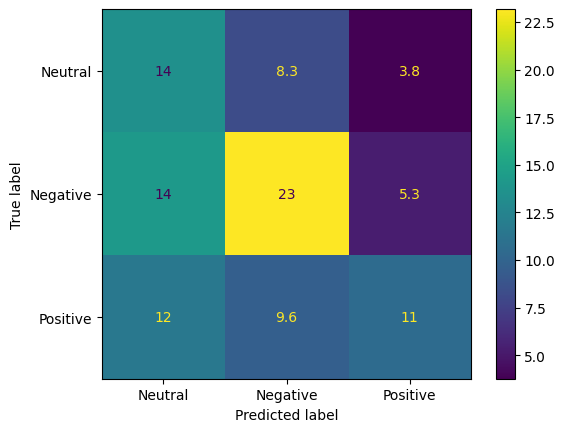

In [30]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

---
# Part (3) - GloVe: Global Vectors for Word Representation

### Create Tokenizer

In [31]:
tokenizer = get_tokenizer("basic_english")

### Load GloVe '6B' Embeddings

In [32]:
cd '/home/dllabsharif/DeepProject/MSCTD/vector_cache'

/home/dllabsharif/DeepProject/MSCTD/vector_cache


In [33]:
global_vectors = GloVe(name='6B', dim=50)

In [34]:
cd '/home/dllabsharif/DeepProject/MSCTD'

/home/dllabsharif/DeepProject/MSCTD


### Hyperparameters

In [35]:
max_words = 10
embed_len = 50

### Create Dataset Class

In [36]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', text_transform=None, random_state=42, clean_pattern=None):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.text_transform = text_transform
        self.clean_pattern = clean_pattern

        
        # clean our texts
        if self.clean_pattern is not None:
            for i in range(len(self.dataframe)):
                text =  re.sub(self.clean_pattern, " ", self.dataframe.text[i])
                text = text.lower().strip()
                self.dataframe.text[i] = text
        else:
            for i in range(len(self.dataframe)):
                text =  self.dataframe.text[i]
                text = text.lower().strip()
                self.dataframe.text[i] = text
                    
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        indexes = self.dataframe.loc[idx, 'indexes']
        tokenized_text = tokenizer(text)
        
        if len(tokenized_text) < max_words:
            tokenized_text = tokenized_text + [""] * (max_words-len(tokenized_text))
        else:
            tokenized_text = tokenized_text[:max_words]
            
        x_tensor = torch.zeros(max_words, embed_len)
        for i, tokens in enumerate(tokenized_text):
            x_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
            
        x_tensor = torch.reshape(x_tensor, (-1,))
    
        return x_tensor, label

In [37]:
train_dataset =  MSCTDDataset(root = './data1', dataset_name = 'train', clean_pattern="[^a-zA-Z]")
test_dataset =  MSCTDDataset(root = './data1', dataset_name = 'test', clean_pattern="[^a-zA-Z]")
dev_dataset =  MSCTDDataset(root = './data1', dataset_name = 'dev', clean_pattern="[^a-zA-Z]")

### Dataloader

In [38]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Neural Network

In [39]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(max_words*embed_len, 3)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, 3)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.fc1(x.to(torch.float))
        x = self.softmax(x)
        
        return x

In [40]:
model_MLP_glove = MLP().to(device)

In [41]:
pytorch_total_params = sum(p.numel() for p in model_MLP_glove.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 1,698


### Training Network

In [42]:
EPOCHS = 10
LR = 2e-3
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_MLP_glove.parameters(), lr=LR)

train(model_MLP_glove, train_loader, dev_loader, LR, EPOCHS, criterion, optimizer)

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.47it/s]


Epochs: 1 | Train Loss:  0.002                 | Train Accuracy:  44.91%                 | Val Loss:  0.002                 | Val Accuracy:  47.09%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.81it/s]


Epochs: 2 | Train Loss:  0.002                 | Train Accuracy:  50.91%                 | Val Loss:  0.002                 | Val Accuracy:  48.75%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.81it/s]


Epochs: 3 | Train Loss:  0.002                 | Train Accuracy:  52.42%                 | Val Loss:  0.002                 | Val Accuracy:  48.63%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.81it/s]


Epochs: 4 | Train Loss:  0.002                 | Train Accuracy:  52.96%                 | Val Loss:  0.002                 | Val Accuracy:  49.61%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.82it/s]


Epochs: 5 | Train Loss:  0.002                 | Train Accuracy:  53.40%                 | Val Loss:  0.002                 | Val Accuracy:  48.47%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.86it/s]


Epochs: 6 | Train Loss:  0.002                 | Train Accuracy:  53.57%                 | Val Loss:  0.002                 | Val Accuracy:  48.67%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.86it/s]


Epochs: 7 | Train Loss:  0.002                 | Train Accuracy:  53.66%                 | Val Loss:  0.002                 | Val Accuracy:  48.79%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.72it/s]


Epochs: 8 | Train Loss:  0.002                 | Train Accuracy:  53.66%                 | Val Loss:  0.002                 | Val Accuracy:  49.46%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.76it/s]


Epochs: 9 | Train Loss:  0.002                 | Train Accuracy:  53.57%                 | Val Loss:  0.002                 | Val Accuracy:  48.51%


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.78it/s]


Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  53.73%                 | Val Loss:  0.002                 | Val Accuracy:  49.04%


### Evaluate Model on Test Data

In [43]:
model_MLP_glove.eval()
y_true, y_pred = evaluate(model_MLP_glove, test_loader)

### Results

Accuracy: 49.69%

F1 score: 48.10%

Confusion Matrix:


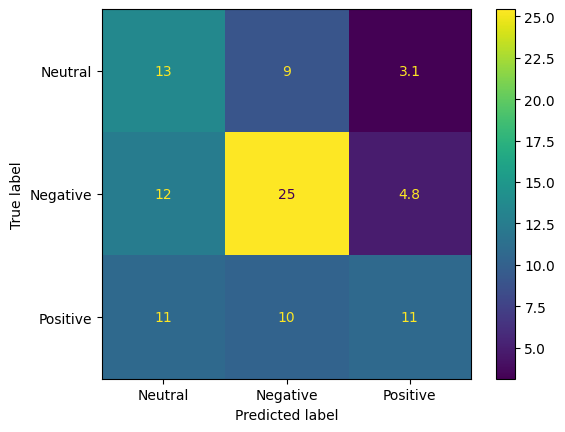

In [44]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

---
# Part (4) - BERT

### BertTokenizer

In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [46]:
max_length = 15

### Create Dataset Class

In [47]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', text_transform=None, random_state=42, clean_pattern=None):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.text_transform = text_transform
        self.clean_pattern = clean_pattern
                    
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        
        
        text_tokenized = tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
        
        


    
        return text_tokenized, np.array(label)

In [48]:
train_dataset =  MSCTDDataset(root = './data1', dataset_name = 'train')
test_dataset =  MSCTDDataset(root = './data1', dataset_name = 'test')
dev_dataset =  MSCTDDataset(root = './data1', dataset_name = 'dev')

### Dataloader

In [49]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Model Building

In [50]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.linear = nn.Linear(768, 3)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        linear_output = self.linear(pooled_output)

        return linear_output

In [51]:
model_BERT = BertClassifier()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
pytorch_total_params = sum(p.numel() for p in model_BERT.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 108,312,579


### Training Loop

In [53]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {100 * total_acc_train / len(train_dataset): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {100 * total_acc_val / len(dev_dataset): .2f}%')

### Training Network

In [54]:
EPOCHS = 2
LR = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BERT.parameters(), lr= LR)
              
train(model_BERT, train_loader, dev_loader, EPOCHS, criterion, optimizer)

100%|█████████████████████████████████████████| 633/633 [00:20<00:00, 30.81it/s]


Epochs: 1 | Train Loss:  0.027                 | Train Accuracy:  60.21%                 | Val Loss:  0.027                 | Val Accuracy:  59.67%


100%|█████████████████████████████████████████| 633/633 [00:20<00:00, 30.79it/s]


Epochs: 2 | Train Loss:  0.020                 | Train Accuracy:  74.48%                 | Val Loss:  0.032                 | Val Accuracy:  58.74%


### Evaluate Model on Test Data

In [55]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device).data.cpu().numpy()
            y_true.extend(test_label) # Save Truth


            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

In [56]:
model_BERT.eval()
y_true, y_pred = evaluate(model_BERT, test_loader)

### Results

Accuracy: 58.34%

F1 score: 57.71%

Confusion Matrix:


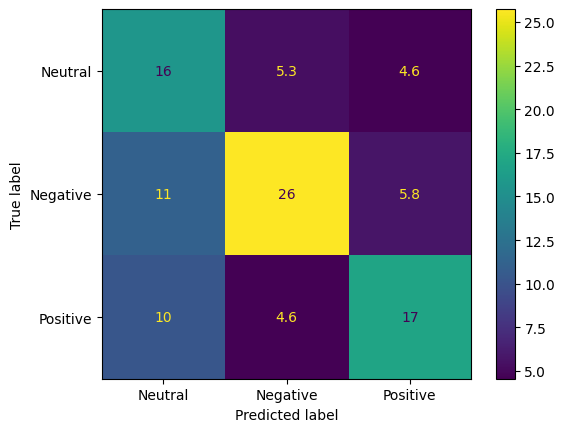

In [57]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

---
# Conclusion

**Summary of phase 2 results:**


*   Part 1 (TF-IDF):

> Accuracy: 49.16%

> F1Score: 44.16%

*   Part 2 (SVM):

> Accuracy: 47.25%

> F1Score: 46.03%

*   Part 3 (GloVe):

> Accuracy: 49.69%

> F1Score: 48.10%

*   Part 4 (BERT):

> Accuracy: 58.34%

> F1Score: 57.71%


### By comparing the above results, it is clearly seen that using the BERT network has outperformed all other methods.